# Download dataset

In [1]:
!kaggle competitions download -c house-prices-advanced-regression-techniques
import zipfile
with zipfile.ZipFile("house-prices-advanced-regression-techniques.zip","r") as zip_f:
    zip_f.extractall("input")

house-prices-advanced-regression-techniques.zip: Skipping, found more recently modified local copy (use --force to force download)


# Important imports


In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()
import numpy as np
import pandas as pd

import catboost
import catboost.datasets
import shap
import sklearn.model_selection

import matplotlib.pyplot as plt
# import plotly.express as px
import seaborn as sns

from scipy import stats
from catboost import CatBoostRegressor, Pool

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, RepeatedKFold
from sklearn.metrics import mean_squared_error as mse
from sklearn.feature_selection import RFECV

import plotly.express as px
import plotly.figure_factory as ff
import scipy.stats as stats
# import eli5
# from eli5.sklearn import PermutationImportance

# import hyperopt
from sklearn import preprocessing
from numpy.random import RandomState
from os import listdir

from catboost.eval.catboost_evaluation import *
from catboost.utils import create_cd

# import shap
# # load JS visualization code to notebook
# shap.initjs()

# Load dataset

## Train


In [3]:
train = pd.read_csv("input/train.csv", index_col=0)
min_max_scaler = preprocessing.MinMaxScaler()

# # normalize numeric colimns  with min max sacller
# for col in train.columns[:len(train.columns)-1]:
#     if pd.to_numeric(train[col], errors='coerce').notnull().all():
#         train[col] = min_max_scaler.fit_transform(train[col].values.reshape(-1,1))

train.head(5)

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
Id                                                                    
1           60       RL         65.0     8450   Pave   NaN      Reg   
2           20       RL         80.0     9600   Pave   NaN      Reg   
3           60       RL         68.0    11250   Pave   NaN      IR1   
4           70       RL         60.0     9550   Pave   NaN      IR1   
5           60       RL         84.0    14260   Pave   NaN      IR1   

   LandContour Utilities LotConfig  ... PoolArea PoolQC Fence MiscFeature  \
Id                                  ...                                     
1          Lvl    AllPub    Inside  ...        0    NaN   NaN         NaN   
2          Lvl    AllPub       FR2  ...        0    NaN   NaN         NaN   
3          Lvl    AllPub    Inside  ...        0    NaN   NaN         NaN   
4          Lvl    AllPub    Corner  ...        0    NaN   NaN         NaN   
5          Lvl    AllPub       FR2  ...        0    NaN   NaN         NaN   

   MiscVal MoSold  YrSold  SaleType  SaleCondition  SalePrice  
Id                                                             
1        0      2    2008        WD         Normal     208500  
2        0      5    2007        WD         Normal     181500  
3        0      9    2008        WD         Normal     223500  
4        0      2    2006        WD        Abnorml     140000  
5        0     12    2008        WD         Normal     250000  

[5 rows x 80 columns]

## Test 


In [4]:
test = pd.read_csv("input/test.csv", index_col=0)

# # normalize numeric colimns  with min max sacller
# for col in test.columns[:len(test.columns)-1]:
#     if pd.to_numeric(test[col], errors='coerce').notnull().all():
#         test[col] = min_max_scaler.fit_transform(test[col].values.reshape(-1,1))

test.head(5)

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
Id                                                                      
1461          20       RH         80.0    11622   Pave   NaN      Reg   
1462          20       RL         81.0    14267   Pave   NaN      IR1   
1463          60       RL         74.0    13830   Pave   NaN      IR1   
1464          60       RL         78.0     9978   Pave   NaN      IR1   
1465         120       RL         43.0     5005   Pave   NaN      IR1   

     LandContour Utilities LotConfig  ... ScreenPorch PoolArea PoolQC  Fence  \
Id                                    ...                                      
1461         Lvl    AllPub    Inside  ...         120        0    NaN  MnPrv   
1462         Lvl    AllPub    Corner  ...           0        0    NaN    NaN   
1463         Lvl    AllPub    Inside  ...           0        0    NaN  MnPrv   
1464         Lvl    AllPub    Inside  ...           0        0    NaN    NaN   
1465         HLS    AllPub    Inside  ...         144        0    NaN    NaN   

     MiscFeature MiscVal  MoSold  YrSold  SaleType  SaleCondition  
Id                                                                 
1461         NaN       0       6    2010        WD         Normal  
1462        Gar2   12500       6    2010        WD         Normal  
1463         NaN       0       3    2010        WD         Normal  
1464         NaN       0       6    2010        WD         Normal  
1465         NaN       0       1    2010        WD         Normal  

[5 rows x 79 columns]

# data view 

output columns with a large number of missing values

MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
Street             0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 80, dtype: int64

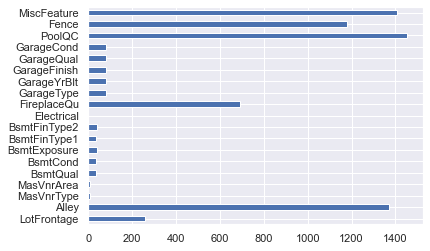

In [5]:
null_features = train.isnull().sum(axis = 0)
null_features[null_features>=1].plot(kind = 'barh')
null_features

delete colomns with more then 300 missing values

In [6]:
#check description to fill missings
train['Fence'] = train['Fence'].fillna('No Fence')
train['Fence'] = [1 if x != 'No Fence' else 0 for x in train.loc[:,'Fence'].values]

train['PoolQC'] = train['PoolQC'].fillna('No Pool')
train['PoolQC'] = [1 if x != 'No Pool' else 0 for x in train.loc[:,'PoolQC'].values]

train['MiscFeature'] = train['MiscFeature'].fillna('None')

train['FireplaceQu'] = train['FireplaceQu'].fillna('No Fireplace')
train['FireplaceQu'] = [1 if x != 'No Fireplace' else 0 for x in train.loc[:,'FireplaceQu'].values]

train['Fence'] = train['Fence'].fillna('No Fence')
train['Fence'] = [1 if x != 'No Fence' else 0 for x in train.loc[:,'Fence'].values]

train['Alley'] = train['Alley'].fillna('No alley access')
train['Alley'] = [1 if x != 'No alley access' else 0 for x in train.loc[:,'Alley'].values]

train['LotFrontage'] = train['LotFrontage'].fillna('0')

train['GarageType'] = train['GarageType'].fillna('No Garage')

train['GarageCond'] = train['GarageCond'].fillna('No Garage')

train['GarageQual'] = train['GarageQual'].fillna('No Garage')

train['GarageFinish'] = train['GarageFinish'].fillna('No Garage')

train['GarageYrBlt'] = train['GarageYrBlt'].fillna('No Garage')
train['GarageYrBlt'] = [1 if x != 'No Garage' else 0 for x in train.loc[:,'GarageYrBlt'].values]

train[ 'BsmtFinType1'] = train['BsmtFinType1'].fillna('No Basement')
train['BsmtFinType2'] = train['BsmtFinType2'].fillna('No Basement')

train['BsmtExposure'] = train['BsmtExposure'].fillna('No Basement')

train['BsmtCond'] = train['BsmtCond'].fillna('No Basement')

train['BsmtQual'] = train['BsmtQual'].fillna('No Basement')

train['MasVnrArea'] = train['MasVnrArea'].fillna('0')


train['MasVnrType'] = train['MasVnrType'].fillna('None')

train['Electrical'] = train['Electrical'].fillna('Mixed')


In [7]:
#check description to fill missings
test['Fence'] = test['Fence'].fillna('No Fence')
test['Fence'] = [1 if x != 'No Fence' else 0 for x in test.loc[:,'Fence'].values]

test['PoolQC'] = test['PoolQC'].fillna('No Pool')
test['PoolQC'] = [1 if x != 'No Pool' else 0 for x in test.loc[:,'PoolQC'].values]

test['MiscFeature'] = test['MiscFeature'].fillna('None')

test['FireplaceQu'] = test['FireplaceQu'].fillna('No Fireplace')
test['FireplaceQu'] = [1 if x != 'No Fireplace' else 0 for x in test.loc[:,'FireplaceQu'].values]

test['Fence'] = test['Fence'].fillna('No Fence')
test['Fence'] = [1 if x != 'No Fence' else 0 for x in test.loc[:,'Fence'].values]

test['Alley'] = test['Alley'].fillna('No alley access')
test['Alley'] = [1 if x != 'No alley access' else 0 for x in test.loc[:,'Alley'].values]

test['LotFrontage'] = test['LotFrontage'].fillna('0')

test['GarageType'] = test['GarageType'].fillna('No Garage')

test['GarageCond'] = test['GarageCond'].fillna('No Garage')

test['GarageQual'] = test['GarageQual'].fillna('No Garage')

test['GarageFinish'] = test['GarageFinish'].fillna('No Garage')

test['GarageYrBlt'] = test['GarageYrBlt'].fillna('No Garage')
test['GarageYrBlt'] = [1 if x != 'No Garage' else 0 for x in test.loc[:,'GarageYrBlt'].values]

test[ 'BsmtFinType1'] = test['BsmtFinType1'].fillna('No Basement')
test['BsmtFinType2'] = test['BsmtFinType2'].fillna('No Basement')

test['BsmtExposure'] = test['BsmtExposure'].fillna('No Basement')

test['BsmtCond'] = test['BsmtCond'].fillna('No Basement')

test['BsmtQual'] = test['BsmtQual'].fillna('No Basement')

test['MasVnrArea'] = test['MasVnrArea'].fillna('0')


test['MasVnrType'] = test['MasVnrType'].fillna('None')

test['Electrical'] = test['Electrical'].fillna('Mixed')

In [8]:
null_features = train.isnull().sum(axis = 0)
if null_features[null_features == '0'].all():
    print('no null features')
else:
    null_features[null_features>=1].plot(kind = 'barh')
    null_features


no null features


### outliers

In [9]:
sale_price_scaled = StandardScaler().fit_transform(train[['SalePrice']])

In [10]:
low = sale_price_scaled[sale_price_scaled[:, 0].argsort()][:10]
high = sale_price_scaled[sale_price_scaled[:, 0].argsort()][-10:]

In [11]:
print(low, '\n\n', high)


[[-1.83870376]
 [-1.83352844]
 [-1.80092766]
 [-1.78329881]
 [-1.77448439]
 [-1.62337999]
 [-1.61708398]
 [-1.58560389]
 [-1.58560389]
 [-1.5731    ]] 

 [[3.82897043]
 [4.04098249]
 [4.49634819]
 [4.71041276]
 [4.73032076]
 [5.06214602]
 [5.42383959]
 [5.59185509]
 [7.10289909]
 [7.22881942]]


In [12]:
import plotly.io as pio; pio.renderers.default='notebook'
fig = px.scatter(train, x='SalePrice', y='GrLivArea', color_discrete_sequence=px.colors.sequential.Rainbow)

fig.update_layout(height=600, width=800, title_text='GrLivArea/SalePrice')
fig.show()

In [13]:
train = train.drop(train.sort_values(by='GrLivArea', ascending=False)[:2].index)

In [14]:
fig = px.scatter(train, x='SalePrice', y='TotalBsmtSF', color_discrete_sequence=px.colors.sequential.Oryel_r)

fig.update_layout(height=600, width=800, title_text='TotalBsmtSF/SalePrice')
fig.show()

In [15]:
train = train.drop(train.sort_values(by='TotalBsmtSF', ascending=False)[:1].index)

In [72]:
# numerical non binar features
num_features = list()
for col in train:
    if train[col].dtypes!="object" and train[col].nunique()>2:
          num_features.append(col)
num_features = num_features[:len(num_features)-1]
print(num_features)

['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']


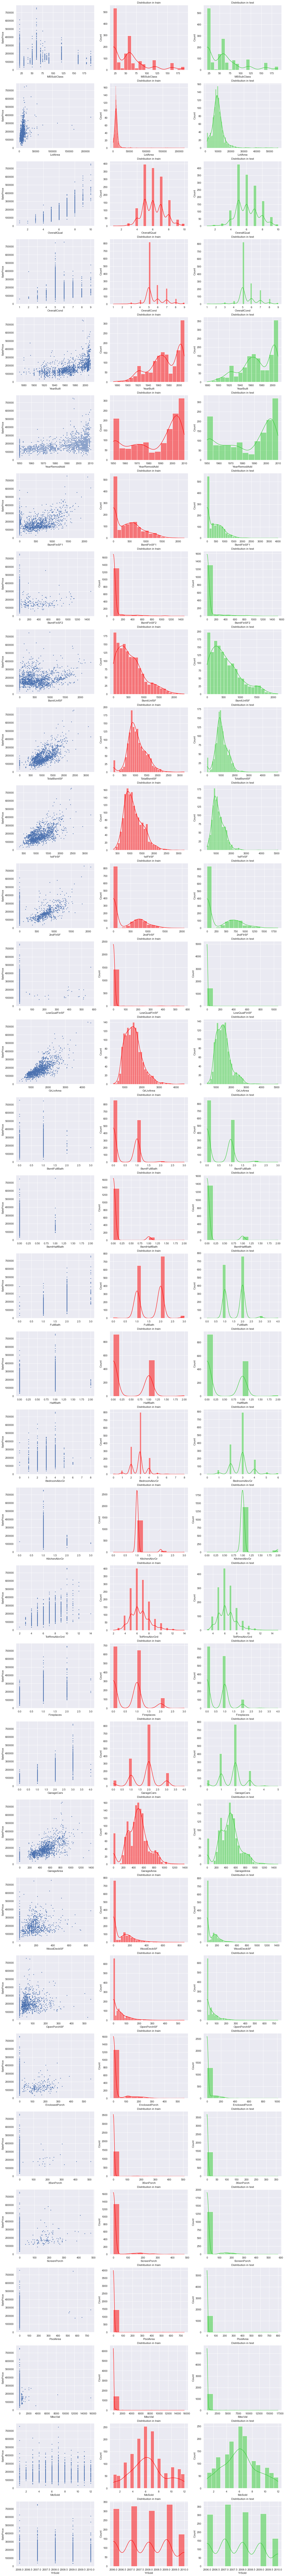

In [75]:
fig, ax = plt.subplots(len(num_features),3,figsize=(20,len(num_features)*6))

for n in range(len(num_features)):
    feat = num_features[n]
    ax[n,0].scatter(train[feat].values, train.SalePrice.values, s=4)
    ax[n,0].set_ylabel("SalePrice")
    ax[n,0].set_xlabel(feat);
    sns.histplot(train[feat], kde=True, ax=ax[n,1], color="red")
    ax[n,1].set_title("Distribution in train")
    
    
    sns.histplot(test[feat], kde=True, ax=ax[n,2], color="limegreen")
    ax[n,2].set_title("Distribution in test")


### Sale Prise Distribution

Text(0.5, 1.0, 'Target distribution in train')

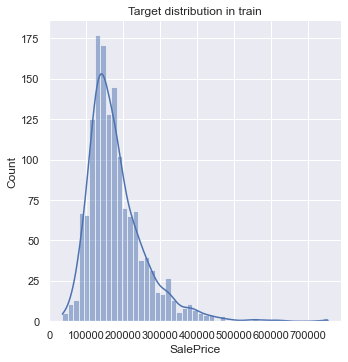

In [76]:
sns.set(rc={'figure.figsize':(50,25)})

sns.displot(train.SalePrice,kde=True)

plt.title("Target distribution in train")

apply the logarithm function to remove outliers

/home/ezrial321/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



Text(0.5, 1.0, 'Log distribution in train')

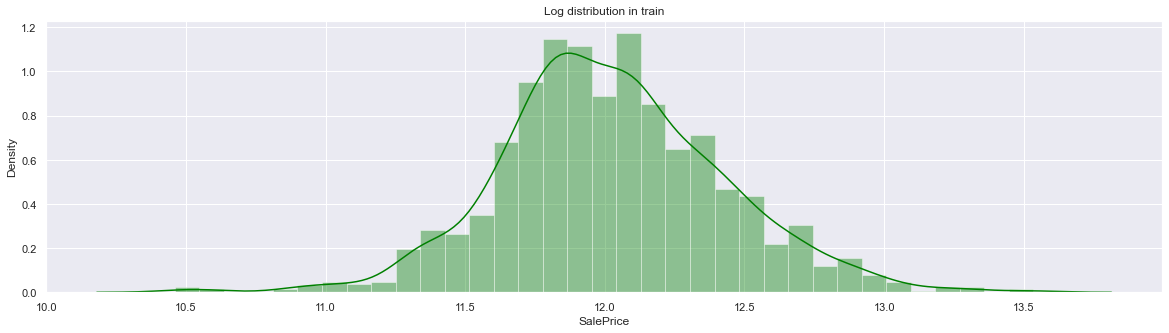

In [77]:
plt.figure(figsize=(20,5))
sns.distplot(np.log(train.SalePrice), color="green")
plt.title("Log distribution in train")

In [78]:
train["SalePrice"] = train.SalePrice.apply(np.log)

In [79]:
num_candidates = list(train.dtypes[train.dtypes!="object"].index.values)
num_candidates

['MSSubClass',
 'LotArea',
 'Alley',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'FireplaceQu',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'PoolQC',
 'Fence',
 'MiscVal',
 'MoSold',
 'YrSold',
 'SalePrice']

/home/ezrial321/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



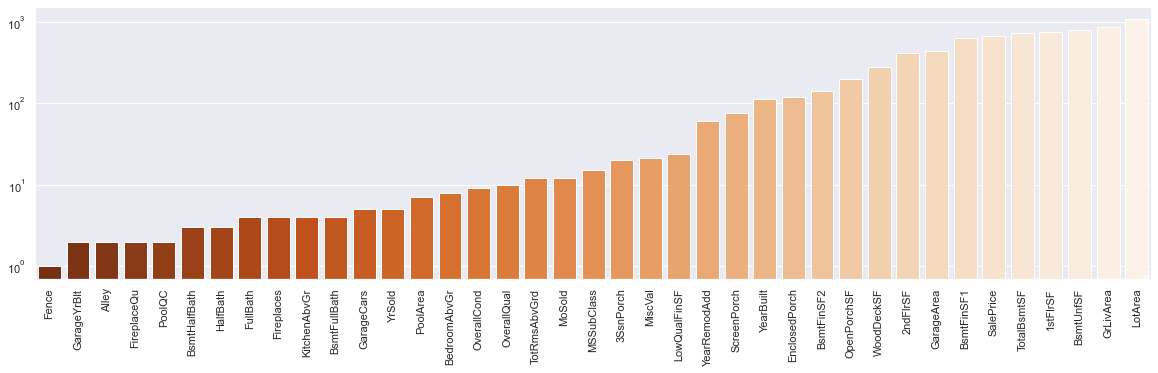

In [80]:
unique_counts = train.loc[:, num_candidates].nunique().sort_values()

plt.figure(figsize=(20,5))
sns.barplot(unique_counts.index, unique_counts.values, palette="Oranges_r")
plt.xticks(rotation=90);
plt.yscale("log")

In [81]:
cat_features = list(train.select_dtypes(include='object').columns)
train[cat_features].describe().T.sort_values('unique', ascending=False)

count unique      top   freq
MasVnrArea     1457.0  325.0      0.0  861.0
LotFrontage      1457    111        0    259
Neighborhood     1457     25    NAmes    225
Exterior2nd      1457     16  VinylSd    503
Exterior1st      1457     15  VinylSd    514
SaleType         1457      9       WD   1266
Condition1       1457      9     Norm   1259
HouseStyle       1457      8   1Story    725
Condition2       1457      8     Norm   1443
RoofMatl         1457      7  CompShg   1432
BsmtFinType2     1457      7      Unf   1254
BsmtFinType1     1457      7      Unf    430
Functional       1457      7      Typ   1357
GarageType       1457      7   Attchd    868
RoofStyle        1457      6    Gable   1140
Electrical       1457      6    SBrkr   1331
GarageQual       1457      6       TA   1308
Heating          1457      6     GasA   1425
GarageCond       1457      6       TA   1323
Foundation       1457      6    PConc    644
SaleCondition    1457      6   Normal   1197
BsmtExposure     1457      5       No    952
HeatingQC        1457      5       Ex    738
MiscFeature      1457      5     None   1403
MSZoning         1457      5       RL   1148
BsmtCond         1457      5       TA   1308
BsmtQual         1457      5       TA    649
BldgType         1457      5     1Fam   1217
LotConfig        1457      5   Inside   1050
ExterCond        1457      5       TA   1279
ExterQual        1457      4       TA    906
MasVnrType       1457      4     None    872
KitchenQual      1457      4       TA    735
GarageFinish     1457      4      Unf    605
LandContour      1457      4      Lvl   1310
LotShape         1457      4      Reg    925
LandSlope        1457      3      Gtl   1379
PavedDrive       1457      3        Y   1337
CentralAir       1457      2        Y   1362
Utilities        1457      2   AllPub   1456
Street           1457      2     Pave   1451

In [82]:
cat_features = list(train.columns[:len(train.columns)-1])
print(*cat_features)

MSSubClass MSZoning LotFrontage LotArea Street Alley LotShape LandContour Utilities LotConfig LandSlope Neighborhood Condition1 Condition2 BldgType HouseStyle OverallQual OverallCond YearBuilt YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure BsmtFinType1 BsmtFinSF1 BsmtFinType2 BsmtFinSF2 BsmtUnfSF TotalBsmtSF Heating HeatingQC CentralAir Electrical 1stFlrSF 2ndFlrSF LowQualFinSF GrLivArea BsmtFullBath BsmtHalfBath FullBath HalfBath BedroomAbvGr KitchenAbvGr KitchenQual TotRmsAbvGrd Functional Fireplaces FireplaceQu GarageType GarageYrBlt GarageFinish GarageCars GarageArea GarageQual GarageCond PavedDrive WoodDeckSF OpenPorchSF EnclosedPorch 3SsnPorch ScreenPorch PoolArea PoolQC Fence MiscFeature MiscVal MoSold YrSold SaleType SaleCondition


In [83]:
# for feature in cat_features:
#     print(f'Feature {feature}')
#     display(train[feature].value_counts())
#     print('-' * 40)

In [84]:
# train.head()

In [85]:


train_X, val_X, train_y, val_y = sklearn.model_selection.train_test_split(
    train.drop(columns=['SalePrice']),
    train['SalePrice'],
    test_size=0.20,
    # stratify=train_df_no_missing['SalePrice'],
    random_state=2021
)

In [86]:
for col in cat_features:
    train_X[col] = train_X[col].astype(str)
    val_X[col] = val_X[col].astype(str)

In [87]:
train_pool = catboost.Pool(
    data = train_X,
    label = train_y,
    cat_features=cat_features
)
val_pool = catboost.Pool(
    data = val_X,
    label = val_y,
    cat_features=cat_features
)
# test_pool = catboost.Pool(
#     test_X,
#     # label=test_y,
#     cat_features=cat_features
# )

In [89]:
catboost_train_dir = 'catboost_clf'

params = {'bagging_temperature': 0.8,
               'depth': 8,
               'iterations': 1500,
               'l2_leaf_reg': 30,
               'learning_rate': 0.05,
               'random_strength': 0.8}

clf = catboost.CatBoostRegressor(
                                **params,
                                 loss_function='RMSE', 
                                 random_seed=2021, 
                                 task_type='GPU')
clf.fit(train_pool, eval_set=val_pool,plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.3863584	test: 0.4164653	best: 0.4164653 (0)	total: 34.4ms	remaining: 51.6s
1:	learn: 0.3796837	test: 0.4092540	best: 0.4092540 (1)	total: 69ms	remaining: 51.7s
2:	learn: 0.3738577	test: 0.4028512	best: 0.4028512 (2)	total: 135ms	remaining: 1m 7s
3:	learn: 0.3670882	test: 0.3965086	best: 0.3965086 (3)	total: 174ms	remaining: 1m 5s
4:	learn: 0.3606582	test: 0.3900365	best: 0.3900365 (4)	total: 212ms	remaining: 1m 3s
5:	learn: 0.3558948	test: 0.3847651	best: 0.3847651 (5)	total: 259ms	remaining: 1m 4s
6:	learn: 0.3502436	test: 0.3788758	best: 0.3788758 (6)	total: 297ms	remaining: 1m 3s
7:	learn: 0.3460413	test: 0.3741497	best: 0.3741497 (7)	total: 342ms	remaining: 1m 3s
8:	learn: 0.3405921	test: 0.3692244	best: 0.3692244 (8)	total: 376ms	remaining: 1m 2s
9:	learn: 0.3356271	test: 0.3647330	best: 0.3647330 (9)	total: 439ms	remaining: 1m 5s
10:	learn: 0.3309961	test: 0.3598629	best: 0.3598629 (10)	total: 478ms	remaining: 1m 4s
11:	learn: 0.3265247	test: 0.3559100	best: 0.3559100

95:	learn: 0.1977379	test: 0.2180228	best: 0.2180228 (95)	total: 4.57s	remaining: 1m 6s
96:	learn: 0.1969449	test: 0.2172351	best: 0.2172351 (96)	total: 4.61s	remaining: 1m 6s
97:	learn: 0.1962122	test: 0.2161364	best: 0.2161364 (97)	total: 4.69s	remaining: 1m 7s
98:	learn: 0.1956500	test: 0.2154731	best: 0.2154731 (98)	total: 4.73s	remaining: 1m 6s
99:	learn: 0.1952212	test: 0.2146778	best: 0.2146778 (99)	total: 4.79s	remaining: 1m 7s
100:	learn: 0.1949746	test: 0.2143702	best: 0.2143702 (100)	total: 4.83s	remaining: 1m 6s
101:	learn: 0.1944227	test: 0.2136144	best: 0.2136144 (101)	total: 4.89s	remaining: 1m 6s
102:	learn: 0.1938252	test: 0.2130599	best: 0.2130599 (102)	total: 4.92s	remaining: 1m 6s
103:	learn: 0.1931054	test: 0.2123040	best: 0.2123040 (103)	total: 4.97s	remaining: 1m 6s
104:	learn: 0.1923364	test: 0.2111879	best: 0.2111879 (104)	total: 5s	remaining: 1m 6s
105:	learn: 0.1921350	test: 0.2109294	best: 0.2109294 (105)	total: 5.05s	remaining: 1m 6s
106:	learn: 0.1916651	t

188:	learn: 0.1760489	test: 0.1889881	best: 0.1889670 (186)	total: 9.03s	remaining: 1m 2s
189:	learn: 0.1759886	test: 0.1888409	best: 0.1888409 (189)	total: 9.07s	remaining: 1m 2s
190:	learn: 0.1759840	test: 0.1888494	best: 0.1888409 (189)	total: 9.11s	remaining: 1m 2s
191:	learn: 0.1758475	test: 0.1887133	best: 0.1887133 (191)	total: 9.17s	remaining: 1m 2s
192:	learn: 0.1758445	test: 0.1887262	best: 0.1887133 (191)	total: 9.21s	remaining: 1m 2s
193:	learn: 0.1758416	test: 0.1887387	best: 0.1887133 (191)	total: 9.25s	remaining: 1m 2s
194:	learn: 0.1756475	test: 0.1885783	best: 0.1885783 (194)	total: 9.3s	remaining: 1m 2s
195:	learn: 0.1756427	test: 0.1885870	best: 0.1885783 (194)	total: 9.33s	remaining: 1m 2s
196:	learn: 0.1755995	test: 0.1885110	best: 0.1885110 (196)	total: 9.37s	remaining: 1m 1s
197:	learn: 0.1754557	test: 0.1884193	best: 0.1884193 (197)	total: 9.41s	remaining: 1m 1s
198:	learn: 0.1754523	test: 0.1884330	best: 0.1884193 (197)	total: 9.44s	remaining: 1m 1s
199:	learn:

281:	learn: 0.1691881	test: 0.1811658	best: 0.1811295 (278)	total: 13.1s	remaining: 56.8s
282:	learn: 0.1691792	test: 0.1811781	best: 0.1811295 (278)	total: 13.2s	remaining: 56.8s
283:	learn: 0.1691747	test: 0.1811895	best: 0.1811295 (278)	total: 13.2s	remaining: 56.7s
284:	learn: 0.1691011	test: 0.1811029	best: 0.1811029 (284)	total: 13.3s	remaining: 56.6s
285:	learn: 0.1690185	test: 0.1809949	best: 0.1809949 (285)	total: 13.3s	remaining: 56.6s
286:	learn: 0.1690137	test: 0.1810065	best: 0.1809949 (285)	total: 13.4s	remaining: 56.5s
287:	learn: 0.1690092	test: 0.1810067	best: 0.1809949 (285)	total: 13.4s	remaining: 56.4s
288:	learn: 0.1689779	test: 0.1809292	best: 0.1809292 (288)	total: 13.4s	remaining: 56.3s
289:	learn: 0.1689738	test: 0.1809296	best: 0.1809292 (288)	total: 13.5s	remaining: 56.3s
290:	learn: 0.1689429	test: 0.1808529	best: 0.1808529 (290)	total: 13.5s	remaining: 56.2s
291:	learn: 0.1689388	test: 0.1808639	best: 0.1808529 (290)	total: 13.6s	remaining: 56.2s
292:	learn

376:	learn: 0.1623492	test: 0.1736021	best: 0.1736021 (376)	total: 17.4s	remaining: 51.7s
377:	learn: 0.1622755	test: 0.1734446	best: 0.1734446 (377)	total: 17.4s	remaining: 51.6s
378:	learn: 0.1622697	test: 0.1734236	best: 0.1734236 (378)	total: 17.4s	remaining: 51.6s
379:	learn: 0.1621352	test: 0.1733224	best: 0.1733224 (379)	total: 17.5s	remaining: 51.5s
380:	learn: 0.1621297	test: 0.1733027	best: 0.1733027 (380)	total: 17.5s	remaining: 51.5s
381:	learn: 0.1621076	test: 0.1733203	best: 0.1733027 (380)	total: 17.6s	remaining: 51.5s
382:	learn: 0.1620758	test: 0.1732691	best: 0.1732691 (382)	total: 17.6s	remaining: 51.4s
383:	learn: 0.1620662	test: 0.1732676	best: 0.1732676 (383)	total: 17.7s	remaining: 51.3s
384:	learn: 0.1620476	test: 0.1732393	best: 0.1732393 (384)	total: 17.7s	remaining: 51.3s
385:	learn: 0.1620296	test: 0.1732115	best: 0.1732115 (385)	total: 17.8s	remaining: 51.3s
386:	learn: 0.1620244	test: 0.1731928	best: 0.1731928 (386)	total: 17.8s	remaining: 51.3s
387:	learn

471:	learn: 0.1564143	test: 0.1662468	best: 0.1662468 (471)	total: 21.5s	remaining: 46.8s
472:	learn: 0.1564023	test: 0.1662882	best: 0.1662468 (471)	total: 21.5s	remaining: 46.7s
473:	learn: 0.1563296	test: 0.1661725	best: 0.1661725 (473)	total: 21.6s	remaining: 46.6s
474:	learn: 0.1562610	test: 0.1660615	best: 0.1660615 (474)	total: 21.6s	remaining: 46.6s
475:	learn: 0.1562422	test: 0.1660783	best: 0.1660615 (474)	total: 21.6s	remaining: 46.5s
476:	learn: 0.1561708	test: 0.1660545	best: 0.1660545 (476)	total: 21.7s	remaining: 46.5s
477:	learn: 0.1561598	test: 0.1660946	best: 0.1660545 (476)	total: 21.7s	remaining: 46.4s
478:	learn: 0.1561452	test: 0.1661141	best: 0.1660545 (476)	total: 21.8s	remaining: 46.4s
479:	learn: 0.1560323	test: 0.1660631	best: 0.1660545 (476)	total: 21.8s	remaining: 46.3s
480:	learn: 0.1560144	test: 0.1660800	best: 0.1660545 (476)	total: 21.8s	remaining: 46.3s
481:	learn: 0.1559377	test: 0.1658850	best: 0.1658850 (481)	total: 21.9s	remaining: 46.2s
482:	learn

564:	learn: 0.1522564	test: 0.1618782	best: 0.1618782 (564)	total: 25.2s	remaining: 41.7s
565:	learn: 0.1521901	test: 0.1617491	best: 0.1617491 (565)	total: 25.3s	remaining: 41.7s
566:	learn: 0.1521793	test: 0.1617312	best: 0.1617312 (566)	total: 25.3s	remaining: 41.6s
567:	learn: 0.1520969	test: 0.1616042	best: 0.1616042 (567)	total: 25.3s	remaining: 41.6s
568:	learn: 0.1520880	test: 0.1615869	best: 0.1615869 (568)	total: 25.4s	remaining: 41.5s
569:	learn: 0.1520793	test: 0.1615699	best: 0.1615699 (569)	total: 25.4s	remaining: 41.5s
570:	learn: 0.1520709	test: 0.1615533	best: 0.1615533 (570)	total: 25.5s	remaining: 41.4s
571:	learn: 0.1520627	test: 0.1615369	best: 0.1615369 (571)	total: 25.5s	remaining: 41.4s
572:	learn: 0.1520137	test: 0.1614806	best: 0.1614806 (572)	total: 25.5s	remaining: 41.3s
573:	learn: 0.1520057	test: 0.1614646	best: 0.1614646 (573)	total: 25.6s	remaining: 41.3s
574:	learn: 0.1519926	test: 0.1614832	best: 0.1614646 (573)	total: 25.6s	remaining: 41.2s
575:	learn

657:	learn: 0.1488626	test: 0.1581219	best: 0.1581145 (656)	total: 28.7s	remaining: 36.8s
658:	learn: 0.1488515	test: 0.1581296	best: 0.1581145 (656)	total: 28.8s	remaining: 36.7s
659:	learn: 0.1487933	test: 0.1580819	best: 0.1580819 (659)	total: 28.8s	remaining: 36.7s
660:	learn: 0.1487139	test: 0.1580385	best: 0.1580385 (660)	total: 28.8s	remaining: 36.6s
661:	learn: 0.1487066	test: 0.1580332	best: 0.1580332 (661)	total: 28.9s	remaining: 36.5s
662:	learn: 0.1486837	test: 0.1579922	best: 0.1579922 (662)	total: 28.9s	remaining: 36.5s
663:	learn: 0.1485700	test: 0.1578929	best: 0.1578929 (663)	total: 29s	remaining: 36.5s
664:	learn: 0.1485493	test: 0.1578929	best: 0.1578929 (663)	total: 29s	remaining: 36.4s
665:	learn: 0.1484930	test: 0.1577851	best: 0.1577851 (665)	total: 29s	remaining: 36.4s
666:	learn: 0.1484540	test: 0.1577073	best: 0.1577073 (666)	total: 29.1s	remaining: 36.3s
667:	learn: 0.1484425	test: 0.1577248	best: 0.1577073 (666)	total: 29.1s	remaining: 36.3s
668:	learn: 0.14

752:	learn: 0.1453178	test: 0.1545854	best: 0.1545854 (752)	total: 32.7s	remaining: 32.5s
753:	learn: 0.1452946	test: 0.1545134	best: 0.1545134 (753)	total: 32.8s	remaining: 32.4s
754:	learn: 0.1452718	test: 0.1544423	best: 0.1544423 (754)	total: 32.8s	remaining: 32.4s
755:	learn: 0.1452264	test: 0.1543881	best: 0.1543881 (755)	total: 32.9s	remaining: 32.4s
756:	learn: 0.1452193	test: 0.1543963	best: 0.1543881 (755)	total: 32.9s	remaining: 32.3s
757:	learn: 0.1452084	test: 0.1543573	best: 0.1543573 (757)	total: 33s	remaining: 32.3s
758:	learn: 0.1451943	test: 0.1543564	best: 0.1543564 (758)	total: 33s	remaining: 32.2s
759:	learn: 0.1451836	test: 0.1543178	best: 0.1543178 (759)	total: 33.1s	remaining: 32.2s
760:	learn: 0.1451730	test: 0.1542796	best: 0.1542796 (760)	total: 33.1s	remaining: 32.1s
761:	learn: 0.1451227	test: 0.1542484	best: 0.1542484 (761)	total: 33.1s	remaining: 32.1s
762:	learn: 0.1450445	test: 0.1542731	best: 0.1542484 (761)	total: 33.2s	remaining: 32s
763:	learn: 0.14

844:	learn: 0.1435851	test: 0.1530810	best: 0.1530810 (844)	total: 36.3s	remaining: 28.2s
845:	learn: 0.1434805	test: 0.1529950	best: 0.1529950 (845)	total: 36.4s	remaining: 28.1s
846:	learn: 0.1434431	test: 0.1529841	best: 0.1529841 (846)	total: 36.4s	remaining: 28.1s
847:	learn: 0.1434088	test: 0.1529578	best: 0.1529578 (847)	total: 36.4s	remaining: 28s
848:	learn: 0.1434032	test: 0.1529597	best: 0.1529578 (847)	total: 36.5s	remaining: 28s
849:	learn: 0.1433978	test: 0.1529619	best: 0.1529578 (847)	total: 36.5s	remaining: 27.9s
850:	learn: 0.1432574	test: 0.1529127	best: 0.1529127 (850)	total: 36.6s	remaining: 27.9s
851:	learn: 0.1431954	test: 0.1528718	best: 0.1528718 (851)	total: 36.6s	remaining: 27.8s
852:	learn: 0.1431699	test: 0.1528135	best: 0.1528135 (852)	total: 36.7s	remaining: 27.8s
853:	learn: 0.1430730	test: 0.1528606	best: 0.1528135 (852)	total: 36.7s	remaining: 27.8s
854:	learn: 0.1430714	test: 0.1528638	best: 0.1528135 (852)	total: 36.7s	remaining: 27.7s
855:	learn: 0.

937:	learn: 0.1416309	test: 0.1523224	best: 0.1522057 (914)	total: 40.1s	remaining: 24.1s
938:	learn: 0.1416289	test: 0.1523175	best: 0.1522057 (914)	total: 40.2s	remaining: 24s
939:	learn: 0.1416270	test: 0.1523127	best: 0.1522057 (914)	total: 40.2s	remaining: 24s
940:	learn: 0.1415562	test: 0.1523654	best: 0.1522057 (914)	total: 40.3s	remaining: 23.9s
941:	learn: 0.1415543	test: 0.1523607	best: 0.1522057 (914)	total: 40.3s	remaining: 23.9s
942:	learn: 0.1415061	test: 0.1523487	best: 0.1522057 (914)	total: 40.3s	remaining: 23.8s
943:	learn: 0.1414590	test: 0.1523078	best: 0.1522057 (914)	total: 40.4s	remaining: 23.8s
944:	learn: 0.1413954	test: 0.1523336	best: 0.1522057 (914)	total: 40.4s	remaining: 23.7s
945:	learn: 0.1413936	test: 0.1523290	best: 0.1522057 (914)	total: 40.5s	remaining: 23.7s
946:	learn: 0.1413701	test: 0.1523107	best: 0.1522057 (914)	total: 40.5s	remaining: 23.6s
947:	learn: 0.1413252	test: 0.1523021	best: 0.1522057 (914)	total: 40.5s	remaining: 23.6s
948:	learn: 0.

1028:	learn: 0.1403157	test: 0.1522111	best: 0.1521735 (1007)	total: 43.8s	remaining: 20.1s
1029:	learn: 0.1403145	test: 0.1522149	best: 0.1521735 (1007)	total: 43.8s	remaining: 20s
1030:	learn: 0.1403133	test: 0.1522187	best: 0.1521735 (1007)	total: 43.9s	remaining: 20s
1031:	learn: 0.1402558	test: 0.1520996	best: 0.1520996 (1031)	total: 43.9s	remaining: 19.9s
1032:	learn: 0.1402410	test: 0.1520995	best: 0.1520995 (1032)	total: 44s	remaining: 19.9s
1033:	learn: 0.1402400	test: 0.1521032	best: 0.1520995 (1032)	total: 44s	remaining: 19.8s
1034:	learn: 0.1402390	test: 0.1521069	best: 0.1520995 (1032)	total: 44.1s	remaining: 19.8s
1035:	learn: 0.1402380	test: 0.1521105	best: 0.1520995 (1032)	total: 44.1s	remaining: 19.7s
1036:	learn: 0.1402367	test: 0.1521144	best: 0.1520995 (1032)	total: 44.1s	remaining: 19.7s
1037:	learn: 0.1402358	test: 0.1521180	best: 0.1520995 (1032)	total: 44.2s	remaining: 19.7s
1038:	learn: 0.1402349	test: 0.1521216	best: 0.1520995 (1032)	total: 44.2s	remaining: 19

1120:	learn: 0.1387235	test: 0.1514792	best: 0.1514792 (1120)	total: 47.6s	remaining: 16.1s
1121:	learn: 0.1387137	test: 0.1514702	best: 0.1514702 (1121)	total: 47.6s	remaining: 16.1s
1122:	learn: 0.1387115	test: 0.1514675	best: 0.1514675 (1122)	total: 47.7s	remaining: 16s
1123:	learn: 0.1387087	test: 0.1514695	best: 0.1514675 (1122)	total: 47.7s	remaining: 16s
1124:	learn: 0.1387059	test: 0.1514716	best: 0.1514675 (1122)	total: 47.8s	remaining: 15.9s
1125:	learn: 0.1387032	test: 0.1514737	best: 0.1514675 (1122)	total: 47.8s	remaining: 15.9s
1126:	learn: 0.1386937	test: 0.1515039	best: 0.1514675 (1122)	total: 47.9s	remaining: 15.8s
1127:	learn: 0.1386806	test: 0.1514913	best: 0.1514675 (1122)	total: 47.9s	remaining: 15.8s
1128:	learn: 0.1386540	test: 0.1514906	best: 0.1514675 (1122)	total: 48s	remaining: 15.8s
1129:	learn: 0.1385664	test: 0.1514191	best: 0.1514191 (1129)	total: 48s	remaining: 15.7s
1130:	learn: 0.1385540	test: 0.1514065	best: 0.1514065 (1130)	total: 48.1s	remaining: 15

1210:	learn: 0.1376923	test: 0.1509372	best: 0.1509221 (1204)	total: 51.3s	remaining: 12.2s
1211:	learn: 0.1376919	test: 0.1509353	best: 0.1509221 (1204)	total: 51.3s	remaining: 12.2s
1212:	learn: 0.1376788	test: 0.1509207	best: 0.1509207 (1212)	total: 51.4s	remaining: 12.2s
1213:	learn: 0.1376247	test: 0.1508869	best: 0.1508869 (1213)	total: 51.4s	remaining: 12.1s
1214:	learn: 0.1375498	test: 0.1508362	best: 0.1508362 (1214)	total: 51.5s	remaining: 12.1s
1215:	learn: 0.1375430	test: 0.1508439	best: 0.1508362 (1214)	total: 51.5s	remaining: 12s
1216:	learn: 0.1375226	test: 0.1507678	best: 0.1507678 (1216)	total: 51.5s	remaining: 12s
1217:	learn: 0.1375160	test: 0.1507744	best: 0.1507678 (1216)	total: 51.6s	remaining: 11.9s
1218:	learn: 0.1375095	test: 0.1507808	best: 0.1507678 (1216)	total: 51.6s	remaining: 11.9s
1219:	learn: 0.1373740	test: 0.1505412	best: 0.1505412 (1219)	total: 51.6s	remaining: 11.9s
1220:	learn: 0.1373565	test: 0.1505409	best: 0.1505409 (1220)	total: 51.7s	remaining

1303:	learn: 0.1360737	test: 0.1498052	best: 0.1498046 (1302)	total: 54.9s	remaining: 8.24s
1304:	learn: 0.1360726	test: 0.1498060	best: 0.1498046 (1302)	total: 54.9s	remaining: 8.2s
1305:	learn: 0.1360526	test: 0.1497952	best: 0.1497952 (1305)	total: 55s	remaining: 8.16s
1306:	learn: 0.1360516	test: 0.1497960	best: 0.1497952 (1305)	total: 55s	remaining: 8.12s
1307:	learn: 0.1360506	test: 0.1497969	best: 0.1497952 (1305)	total: 55s	remaining: 8.08s
1308:	learn: 0.1360497	test: 0.1497980	best: 0.1497952 (1305)	total: 55.1s	remaining: 8.04s
1309:	learn: 0.1360270	test: 0.1498028	best: 0.1497952 (1305)	total: 55.1s	remaining: 7.99s
1310:	learn: 0.1360177	test: 0.1497939	best: 0.1497939 (1310)	total: 55.1s	remaining: 7.95s
1311:	learn: 0.1360169	test: 0.1497951	best: 0.1497939 (1310)	total: 55.2s	remaining: 7.91s
1312:	learn: 0.1360161	test: 0.1497963	best: 0.1497939 (1310)	total: 55.2s	remaining: 7.86s
1313:	learn: 0.1360154	test: 0.1497976	best: 0.1497939 (1310)	total: 55.3s	remaining: 7

1393:	learn: 0.1347001	test: 0.1485292	best: 0.1485292 (1393)	total: 58.3s	remaining: 4.44s
1394:	learn: 0.1346930	test: 0.1485198	best: 0.1485198 (1394)	total: 58.4s	remaining: 4.39s
1395:	learn: 0.1346859	test: 0.1485105	best: 0.1485105 (1395)	total: 58.4s	remaining: 4.35s
1396:	learn: 0.1346789	test: 0.1485015	best: 0.1485015 (1396)	total: 58.5s	remaining: 4.31s
1397:	learn: 0.1346354	test: 0.1484505	best: 0.1484505 (1397)	total: 58.5s	remaining: 4.27s
1398:	learn: 0.1346219	test: 0.1483893	best: 0.1483893 (1398)	total: 58.6s	remaining: 4.23s
1399:	learn: 0.1346150	test: 0.1483805	best: 0.1483805 (1399)	total: 58.6s	remaining: 4.18s
1400:	learn: 0.1345981	test: 0.1483857	best: 0.1483805 (1399)	total: 58.6s	remaining: 4.14s
1401:	learn: 0.1345913	test: 0.1483770	best: 0.1483770 (1401)	total: 58.7s	remaining: 4.1s
1402:	learn: 0.1345846	test: 0.1483685	best: 0.1483685 (1402)	total: 58.7s	remaining: 4.06s
1403:	learn: 0.1345780	test: 0.1483602	best: 0.1483602 (1403)	total: 58.8s	remain

1484:	learn: 0.1324059	test: 0.1484210	best: 0.1480356 (1465)	total: 1m 2s	remaining: 627ms
1485:	learn: 0.1324046	test: 0.1484242	best: 0.1480356 (1465)	total: 1m 2s	remaining: 585ms
1486:	learn: 0.1324033	test: 0.1484274	best: 0.1480356 (1465)	total: 1m 2s	remaining: 543ms
1487:	learn: 0.1324021	test: 0.1484305	best: 0.1480356 (1465)	total: 1m 2s	remaining: 501ms
1488:	learn: 0.1323812	test: 0.1484618	best: 0.1480356 (1465)	total: 1m 2s	remaining: 459ms
1489:	learn: 0.1323577	test: 0.1484235	best: 0.1480356 (1465)	total: 1m 2s	remaining: 418ms
1490:	learn: 0.1323565	test: 0.1484265	best: 0.1480356 (1465)	total: 1m 2s	remaining: 376ms
1491:	learn: 0.1323554	test: 0.1484294	best: 0.1480356 (1465)	total: 1m 2s	remaining: 334ms
1492:	learn: 0.1323171	test: 0.1483610	best: 0.1480356 (1465)	total: 1m 2s	remaining: 292ms
1493:	learn: 0.1322731	test: 0.1484152	best: 0.1480356 (1465)	total: 1m 2s	remaining: 251ms
1494:	learn: 0.1322454	test: 0.1484186	best: 0.1480356 (1465)	total: 1m 2s	remai

In [92]:
test_metrics = clf.eval_metrics(
    val_pool,
    metrics=['RMSE'],
    ntree_start=clf.best_iteration_ - 1,
    ntree_end=clf.best_iteration_,
    eval_period=1,
    thread_count=-1
)

In [93]:
test_metrics

{'RMSE': [0.14806082532975265]}

In [ ]:
sorted(
    zip(train_X.columns, clf.feature_importances_), 
    key=lambda p: p[1], 
    reverse=True
)

shap_info = clf.get_feature_importance(
    data=train_pool, 
    type='ShapValues', 
    verbose=10000
)
shap_values = shap_info[:,:-1]
base_values = shap_info[:,-1]
shap.summary_plot(shap_values, train_X)

In [ ]:
train_X.columns[:12]

In [ ]:
sorted_feature_importance = clf.feature_importances_.argsort()
plt.barh(train_X.columns[sorted_feature_importance],clf.feature_importances_[sorted_feature_importance], 
        color='turquoise')
plt.xlabel("CatBoost Feature Importance")


In [ ]:
test = test.applymap(str)
pred = clf.predict(test)

In [94]:
from sklearn.preprocessing import LabelEncoder

str_columns = list(train.select_dtypes(include='object').columns)
print(str_columns)

['MSZoning', 'LotFrontage', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'MiscFeature', 'SaleType', 'SaleCondition']


In [130]:
for col in str_columns:
    label_enc = LabelEncoder()
    label_enc.fit(list(train[col].values))
    train[col] = label_enc.transform(list(train[col].values))
for col in str_columns:
    label_enc = LabelEncoder()
    label_enc.fit(list(test[col].values))
    test[col] = label_enc.transform(list(test[col].values))

In [98]:
train.head()

MSSubClass  MSZoning  LotFrontage  LotArea  Street  Alley  LotShape  \
Id                                                                        
1           60         3           76     8450       1      0         3   
2           20         3           91     9600       1      0         3   
3           60         3           79    11250       1      0         0   
4           70         3           71     9550       1      0         0   
5           60         3           95    14260       1      0         0   

    LandContour  Utilities  LotConfig  ...  PoolArea  PoolQC  Fence  \
Id                                     ...                            
1             3          0          4  ...         0       0      1   
2             3          0          2  ...         0       0      1   
3             3          0          4  ...         0       0      1   
4             3          0          0  ...         0       0      1   
5             3          0          2  ...         0       0      1   

    MiscFeature  MiscVal  MoSold  YrSold  SaleType  SaleCondition  SalePrice  
Id                                                                            
1             1        0       2    2008         8              4  12.247694  
2             1        0       5    2007         8              4  12.109011  
3             1        0       9    2008         8              4  12.317167  
4             1        0       2    2006         8              0  11.849398  
5             1        0      12    2008         8              4  12.429216  

[5 rows x 80 columns]

In [131]:
test.head()

MSSubClass  MSZoning  LotFrontage  LotArea  Street  Alley  LotShape  \
Id                                                                          
1461          20         2           96    11622       1      0         3   
1462          20         3           97    14267       1      0         0   
1463          60         3           90    13830       1      0         0   
1464          60         3           94     9978       1      0         0   
1465         120         3           59     5005       1      0         0   

      LandContour  Utilities  LotConfig  ...  ScreenPorch  PoolArea  PoolQC  \
Id                                       ...                                  
1461            3          0          4  ...          120         0       0   
1462            3          0          0  ...            0         0       0   
1463            3          0          4  ...            0         0       0   
1464            3          0          4  ...            0         0       0   
1465            1          0          4  ...          144         0       0   

      Fence  MiscFeature  MiscVal  MoSold  YrSold  SaleType  SaleCondition  
Id                                                                          
1461      1            1        0       6    2010         8              4  
1462      1            0    12500       6    2010         8              4  
1463      1            1        0       3    2010         8              4  
1464      1            1        0       6    2010         8              4  
1465      1            1        0       1    2010         8              4  

[5 rows x 79 columns]

In [99]:
train_X, val_X, train_y, val_y = sklearn.model_selection.train_test_split(
    train.drop(columns=['SalePrice']),
    train['SalePrice'],
    test_size=0.20,
    # stratify=train_df_no_missing['SalePrice'],
    random_state=2021
)

In [101]:
import xgboost as xgb

from sklearn.linear_model import ElasticNet, Lasso, LinearRegression
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

In [109]:
folds_count = 6

def rmse_cv(model):
    kf_splits = KFold(n_splits=folds_count, random_state=42, shuffle=True).get_n_splits(train_X)
    rmse_score = np.sqrt(-cross_val_score(model, train_X, train_y, cv=kf_splits, n_jobs=-1, scoring='neg_mean_squared_error'))

    return np.array(rmse_score)

def rmsle(y, y_prediction):
    return np.sqrt(mean_squared_error(y, y_prediction))

In [117]:
elastic_model = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, random_state=3, l1_ratio=.9))

print(f'RMSE on cross-validation: {rmse_cv(elastic_model).mean()}')

RMSE on cross-validation: 0.125632393773646


In [110]:
lasso_model = make_pipeline(RobustScaler(), Lasso(alpha=0.0005, random_state=1))

print(f'RMSE on cross-validation: {rmse_cv(lasso_model).mean()}')

RMSE on cross-validation: 0.12538033450095976


In [111]:
linear_regression_model = make_pipeline(RobustScaler(), LinearRegression(normalize=False))

print(f'RMSE on cross-validation: {rmse_cv(linear_regression_model).mean()}')

RMSE on cross-validation: 0.12795311231131926


In [136]:
XGB = xgb.XGBRegressor(max_depth=2,learning_rate=0.1,n_estimators=1000,reg_alpha=0.001,reg_lambda=0.000001,n_jobs=-1,min_child_weight=3)
XGB.fit(train_X,train_y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=2,
             min_child_weight=3, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=-1, num_parallel_tree=1, random_state=0,
             reg_alpha=0.001, reg_lambda=1e-06, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [137]:
print ("Training score:",XGB.score(train_X,train_y),"Test Score:",XGB.score(val_X,val_y))


Training score: 0.9852429180295482 Test Score: 0.9182343534009245


[23:45:43] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4603, gamma=0.0468,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.04, max_delta_step=0, max_depth=3,
             min_child_weight=1.7817, missing=nan, monotone_constraints='()',
             n_estimators=2400, n_jobs=12, nthread=-1, num_parallel_tree=1,
             random_state=7, reg_alpha=0.464, reg_lambda=0.8571,
             scale_pos_weight=1, silent=1, subsample=0.5213,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [138]:
xgb_pred = np.exp(xgb_model.predict(test))

In [140]:
submission = pd.DataFrame()
sample_submission = pd.read_csv('input/sample_submission.csv',header = 0)
submission['Id'] = sample_submission.Id
submission['SalePrice'] = xgb_pred
submission.to_csv('submission.csv', index=False)
submission.head(5)

Id      SalePrice
0  1461  125698.203125
1  1462  156120.093750
2  1463  179619.953125
3  1464  190569.453125
4  1465  192373.906250

In [141]:
!kaggle competitions submit -c house-prices-advanced-regression-techniques -f submission.csv -m 'first try'

100%|██████████████████████████████████████| 21.1k/21.1k [00:04<00:00, 5.26kB/s]
Successfully submitted to House Prices - Advanced Regression Techniques